In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import requests
import pickle

# Display all columns in Pandas DataFrame
pd.set_option('display.max_columns', None)

In [2]:
# Load the dataset
songs = pd.read_csv('songs.csv')

# Copy artist name for consistency
songs['artist_name'] = songs['track_artist']

# Separate numerical and categorical columns
numerical_columns = [col for col in songs.columns if songs[col].dtypes != 'O']
categorical_columns = [col for col in songs.columns if songs[col].dtypes == 'O']

In [3]:
# Convert lyrics to lowercase and process them
songs['lyrics'] = songs['lyrics'].astype(str).str.lower()
songs['lyrics'] = songs['lyrics'].apply(lambda x: x.replace('\n', ' ').split(' '))

# Process track artist and playlist genre
songs['track_artist'] = songs['track_artist'].apply(lambda x: x.replace(' ', '').split(' '))
songs['playlist_genre'] = songs['playlist_genre'].apply(lambda x: x.replace(' ', '').split(' '))

# Create a combined 'tags' column for each song
songs['tags'] = songs['lyrics'] + songs['track_artist'] + songs['playlist_genre']

# Convert list of words into a single string
songs['tags'] = songs['tags'].apply(lambda x: " ".join(x))

# Remove unnecessary characters
songs['tags'] = songs['tags'].apply(lambda x: x.replace(r"\'", "'"))

In [4]:
# Download NLTK stopwords and tokenizer
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize tags
def clean_tags(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    words = word_tokenize(text)  # Tokenize words
    filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(filtered_words)

# Apply cleaning function
songs['tags'] = songs['tags'].apply(clean_tags)

# Tokenize the tags column
songs['tags_tokenized'] = songs['tags'].apply(lambda x: x.split())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [5]:
# Train Word2Vec model on tokenized tags
model = Word2Vec(songs['tags_tokenized'], vector_size=300, window=5, min_count=1, workers=4)

# Function to get document vector from tokenized words
def get_doc_vector(tags_tokenized, model):
    vectors = [model.wv[word] for word in tags_tokenized if word in model.wv]
    return np.mean(vectors, axis=0) if len(vectors) > 0 else np.zeros(300)

# Apply function to compute document vectors
songs['doc_vector'] = songs['tags_tokenized'].apply(lambda x: get_doc_vector(x, model))

In [6]:
# Remove 'duration_ms' before scaling as it is not needed
num_features = [col for col in songs.columns if songs[col].dtypes != 'O']
num_features.remove('duration_ms')

# Apply MinMaxScaler
scaler = MinMaxScaler()
songs[num_features] = scaler.fit_transform(songs[num_features])

In [7]:
# Convert numerical features into a NumPy array
numerical_vectors = songs[num_features].values

# Function to merge Word2Vec document vector and scaled numerical features
def combine_vectors(row, numerical_vector):
    doc_vector = np.array(row['doc_vector'])  # Convert Word2Vec embedding to NumPy array
    return np.concatenate([doc_vector, numerical_vector])  # Merge both vectors

# Apply combination of vectors
songs['combined_vector'] = [
    combine_vectors(row, numerical_vectors[i]) for i, row in songs.iterrows()
]

# Create similarity matrix using the combined vector
combined_vector_matrix = np.vstack(songs['combined_vector'].values)
similarity_matrix = cosine_similarity(combined_vector_matrix, combined_vector_matrix)

In [8]:
# Save Word2Vec model
model.save("word2vec_model.bin")

# Save similarity matrix
with open("similarity_matrix.pkl", "wb") as f:
    pickle.dump(similarity_matrix, f)

In [9]:
def get_recommendation(song_name, similarity_matrix, songs):
    try:
        # Find exact match
        matches = songs[songs['track_name'].str.lower().str.strip() == song_name.lower().strip()]
        song_index = matches.index[0]  # Pick the first matching song index
    
    except Exception as e:
        return f"Error: {e}", []

    # Compute similarity scores
    sim_scores = list(enumerate(similarity_matrix[song_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top 6 similar songs (excluding itself)
    top_similar_songs = sim_scores[1:7]

    # Extract recommended song names
    recommended_songs = [songs.iloc[i[0]]['track_name'] for i in top_similar_songs]

    return recommended_songs

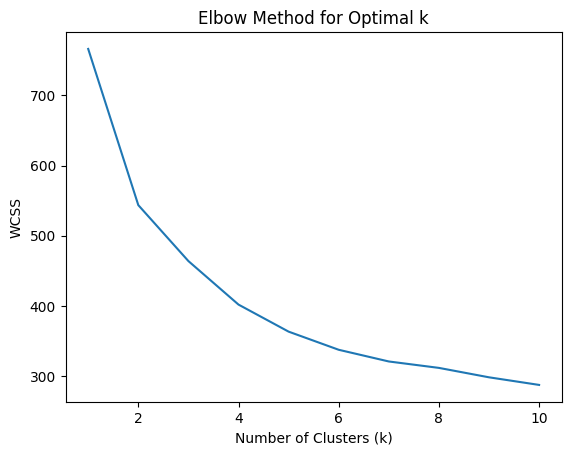

In [10]:
# Determine optimal clusters using Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(songs[num_features])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(range(1, 11), wcss)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.show()

# Apply KMeans clustering with k=5 (as an example)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
songs['cluster'] = kmeans.fit_predict(songs[num_features])

# Save cluster data
songs.to_csv('songs_cleaned.csv', index=False)

In [11]:
def get_access_token(client_id, client_secret):
    url = "https://accounts.spotify.com/api/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {"grant_type": "client_credentials", "client_id": client_id, "client_secret": client_secret}
    
    response = requests.post(url, headers=headers, data=data)
    
    if response.status_code == 200:
        return response.json().get("access_token")
    else:
        print("Error getting access token:", response.json())
        return None

def get_track_details(track_id, token):
    url = f"https://api.spotify.com/v1/tracks/{track_id}"
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        track_data = response.json()
        image_url = track_data.get('album', {}).get('images', [{}])[0].get('url')
        spotify_url = track_data.get('external_urls', {}).get('spotify', None)
        return image_url, spotify_url
    else:
        return None, None